In [2]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
    
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1729492057.987532   16647 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729492058.035752   16647 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729492058.037454   16647 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [4]:
prefix = 's3://danylo-ucla/app/storage/weather/jobs/transform_batch/20220925-014051_e32aa567fa482e970513332d1d24fd51'

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

condition_window = 24
prediction_window = 24
features_length = 9

In [5]:
test_size = 81600

new_val_X = train_X.iloc[-test_size:]
new_val_y = train_y.iloc[-test_size:]

# Remove the last 10% from train_X and train_y
train_X = train_X.iloc[:-test_size]
train_y = train_y.iloc[:-test_size]

# Combine current test and validation sets to form the new validation set
new_validate_X = pd.concat([validate_X,test_X], axis=0)
new_validate_y = pd.concat([validate_y,test_y], axis=0)

test_X = new_validate_X
test_y = new_validate_y
validate_X=new_val_X
validate_y=new_val_y

In [6]:
# Function to check for NaN values in a DataFrame
def check_for_nan(df, dataset_name):
    nan_count = df.isna().sum().sum()
    if nan_count > 0:
        print(f"{dataset_name} contains {nan_count} NaN values.")
    else:
        print(f"{dataset_name} has no NaN values.")

# Check for NaN values in each dataset
check_for_nan(train_X, 'Train X')
check_for_nan(validate_X, 'Validate X')
check_for_nan(test_X, 'Test X')
check_for_nan(score_X, 'Score X')


Train X has no NaN values.
Validate X has no NaN values.
Test X has no NaN values.
Score X has no NaN values.


In [7]:
# Manual dictionary with city coordinates
# Recreate the manual dictionary with additional missing cities included
manual_city_coordinates = {
    'Albuquerque': (35.0844, -106.6504),
    'Atlanta': (33.7490, -84.3880),
    'Boston': (42.3601, -71.0589),
    'Charlotte': (35.2271, -80.8431),
    'Chicago': (41.8781, -87.6298),
    'Dallas': (32.7767, -96.7970),
    'Denver': (39.7392, -104.9903),
    'Detroit': (42.3314, -83.0458),
    'Eilat': (29.5577, 34.9519),
    'Haifa': (32.7940, 34.9896),
    'Houston': (29.7604, -95.3698),
    'Indianapolis': (39.7684, -86.1581),
    'Jacksonville': (30.3322, -81.6557),
    'Jerusalem': (31.7683, 35.2137),
    'Kansas City': (39.0997, -94.5786),
    'Las Vegas': (36.1699, -115.1398),
    'Los Angeles': (34.0522, -118.2437),
    'Miami': (25.7617, -80.1918),
    'Minneapolis': (44.9778, -93.2650),
    'Montreal': (45.5017, -73.5673),
    'Nahariyya': (33.0061, 35.0944),
    'Nashville': (36.1627, -86.7816),
    'New York': (40.7128, -74.0060),
    'Philadelphia': (39.9526, -75.1652),
    'Phoenix': (33.4484, -112.0740),
    'Pittsburgh': (40.4406, -79.9959),
    'Portland': (45.5122, -122.6587),
    'Saint Louis': (38.6270, -90.1994),
    'San Antonio': (29.4241, -98.4936),
    'San Diego': (32.7157, -117.1611),
    'San Francisco': (37.7749, -122.4194),
    'Seattle': (47.6062, -122.3321),
    'Tel Aviv District': (32.0853, 34.7818),
    'Toronto': (43.6532, -79.3832),
    'Vancouver': (49.2827, -123.1207)
}

# Updated function to add lat/long based on city names
def extract_features_with_updated_coordinates(df_X):
    # Extract City from the 'sample' column
    df_X['city'] = df_X.index.get_level_values('sample').str.split('/').str[0]

    # Convert 'time' column to datetime
    df_X['times'] = pd.to_datetime(df_X.index.get_level_values('time'))

    # Extract month, day, hour, and time of day
    df_X['month'] = df_X['times'].dt.month
    df_X['day'] = df_X['times'].dt.day
    df_X['hour'] = df_X['times'].dt.hour

    # Map city to its latitude and longitude
    df_X['latitude'] = df_X['city'].map(lambda city: manual_city_coordinates.get(city, (None, None))[0])
    df_X['longitude'] = df_X['city'].map(lambda city: manual_city_coordinates.get(city, (None, None))[1])
    
    return df_X


# Helper function to extract features and add lat/long
def extract_features_with_coordinates(df_X):
    # Extract City from the 'sample' column
    df_X['city'] = df_X.index.get_level_values('sample').str.split('/').str[0]

    # Convert 'time' column to datetime
    df_X['times'] = pd.to_datetime(df_X.index.get_level_values('time'))

    # Extract month, day, hour, and time of day
    df_X['month'] = df_X['times'].dt.month
    df_X['day'] = df_X['times'].dt.day
    df_X['hour'] = df_X['times'].dt.hour

    # Map city to its latitude and longitude
    df_X['latitude'] = df_X['city'].map(lambda city: manual_city_coordinates.get(city, (None, None))[0])
    df_X['longitude'] = df_X['city'].map(lambda city: manual_city_coordinates.get(city, (None, None))[1])
    
    return df_X

# Apply the function to all datasets
train_X = extract_features_with_coordinates(train_X)
validate_X = extract_features_with_coordinates(validate_X)
test_X = extract_features_with_coordinates(test_X)
score_X = extract_features_with_coordinates(score_X)
train_y = extract_features_with_coordinates(train_y)
validate_y = extract_features_with_coordinates(validate_y)
test_y = extract_features_with_coordinates(test_y)

# Confirm new shapes and check the newly added features
print("Train X shape:", train_X.shape)
print("Train y shape:", train_y.shape)
print("Validation X shape:", validate_X.shape)
print("Validation y shape:", validate_y.shape)
print("Test X shape:", test_X.shape)
print("Test y shape:", test_y.shape)


Train X shape: (744864, 11)
Train y shape: (744864, 11)
Validation X shape: (81600, 11)
Validation y shape: (81600, 11)
Test X shape: (107160, 11)
Test y shape: (107160, 11)


In [8]:
# Function to check for NaN values in a DataFrame
def check_for_nan(df, dataset_name):
    nan_count = df.isna().sum().sum()
    if nan_count > 0:
        print(f"{dataset_name} contains {nan_count} NaN values.")
    else:
        print(f"{dataset_name} has no NaN values.")

# Check for NaN values in each dataset
check_for_nan(train_X, 'Train X')
check_for_nan(validate_X, 'Validate X')
check_for_nan(test_X, 'Test X')
check_for_nan(score_X, 'Score X')


Train X has no NaN values.
Validate X has no NaN values.
Test X has no NaN values.
Score X has no NaN values.


In [9]:
# Function to display unique cities from the 'city' column of a DataFrame
def display_unique_cities(df, dataset_name):
    unique_cities = df['city'].unique()
    print(f"Unique cities in {dataset_name}:")
    print(unique_cities)
    print(f"Total unique cities: {len(unique_cities)}\n")

# Display unique cities for each dataset
display_unique_cities(train_X, 'Train X')
display_unique_cities(validate_X, 'Validate X')
display_unique_cities(test_X, 'Test X')
display_unique_cities(score_X, 'Score X')


Unique cities in Train X:
['Albuquerque' 'Atlanta' 'Boston' 'Charlotte' 'Chicago' 'Dallas' 'Denver'
 'Detroit' 'Eilat' 'Haifa' 'Houston' 'Indianapolis' 'Jacksonville'
 'Jerusalem' 'Kansas City' 'Las Vegas' 'Los Angeles' 'Miami' 'Minneapolis'
 'Montreal' 'Nahariyya' 'Nashville' 'New York' 'Philadelphia' 'Phoenix'
 'Pittsburgh' 'Portland' 'Saint Louis' 'San Antonio' 'San Diego'
 'San Francisco' 'Seattle']
Total unique cities: 32

Unique cities in Validate X:
['Seattle' 'Tel Aviv District' 'Toronto' 'Vancouver']
Total unique cities: 4

Unique cities in Test X:
['Albuquerque' 'Atlanta' 'Boston' 'Charlotte' 'Chicago' 'Dallas' 'Denver'
 'Detroit' 'Eilat' 'Houston' 'Indianapolis' 'Jacksonville' 'Jerusalem'
 'Kansas City' 'Las Vegas' 'Miami' 'Minneapolis' 'Montreal' 'Nashville'
 'New York' 'Philadelphia' 'Pittsburgh' 'Portland' 'Saint Louis'
 'San Antonio' 'San Diego' 'San Francisco' 'Seattle' 'Toronto' 'Vancouver'
 'Phoenix' 'Tel Aviv District']
Total unique cities: 32

Unique cities in Score

In [10]:
# Function to check for NaN values in the 'city' column of a DataFrame
def check_nan_in_city_column(df, dataset_name):
    nan_count = df['latitude'].isna().sum()
    if nan_count > 0:
        print(f"{dataset_name} contains {nan_count} NaN values in the 'city' column.")
    else:
        print(f"{dataset_name} has no NaN values in the 'city' column.")

# Check for NaN values in the 'city' column of each dataset
check_nan_in_city_column(train_X, 'Train X')
check_nan_in_city_column(validate_X, 'Validate X')
check_nan_in_city_column(test_X, 'Test X')
check_nan_in_city_column(score_X, 'Score X')


Train X has no NaN values in the 'city' column.
Validate X has no NaN values in the 'city' column.
Test X has no NaN values in the 'city' column.
Score X has no NaN values in the 'city' column.


In [11]:
# # Function to check if a dataset's cities are a subset of Train X cities
# def is_subset_of_train(train_df, other_df, dataset_name):
#     train_cities = set(train_df['city'].unique())
#     other_cities = set(other_df['city'].unique())
    
#     if other_cities.issubset(train_cities):
#         print(f"All cities in {dataset_name} are a subset of Train X.")
#     else:
#         print(f"{dataset_name} contains cities not present in Train X.")
#         missing_cities = other_cities - train_cities
#         print(f"Missing cities: {missing_cities}\n")

# # Check if Validate X, Test X, and Score X are subsets of Train X
# is_subset_of_train(train_X, validate_X, 'Validate X')
# is_subset_of_train(train_X, test_X, 'Test X')
# is_subset_of_train(train_X, score_X, 'Score X')


In [12]:
train_X.head()
# train_y.head()

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/1108/0 2015-02-16 09:00:00   276.323000      47.0    1031.0   
                   2015-02-16 10:00:00   275.097667      45.0    1032.0   
                   2015-02-16 11:00:00   273.931333      48.0    1032.0   
                   2015-02-16 12:00:00   274.380000      46.0    1033.0   
                   2015-02-16 13:00:00   272.675333      51.0    1033.0   

                                        wind_speed         city  \
sample             time                                           
Albuquerque/1108/0 2015-02-16 09:00:00         3.0  Albuquerque   
                   2015-02-16 10:00:00         3.0  Albuquerque   
                   2015-02-16 11:00:00         2.0  Albuquerque   
                   2015-02-16 12:00:00         2.0  Albuquerque   
                   2015-02-16 13:00:00         1.0  Albuquerque   

                                                     times  month  day  hour  \
sample             time                                                        
Albuquerque/1108/0 2015-02-16 09:00:00 2015-02-16 09:00:00      2   16     9   
                   2015-02-16 10:00:00 2015-02-16 10:00:00      2   16    10   
                   2015-02-16 11:00:00 2015-02-16 11:00:00      2   16    11   
                   2015-02-16 12:00:00 2015-02-16 12:00:00      2   16    12   
                   2015-02-16 13:00:00 2015-02-16 13:00:00      2   16    13   

                                        latitude  longitude  
sample             time                                      
Albuquerque/1108/0 2015-02-16 09:00:00   35.0844  -106.6504  
                   2015-02-16 10:00:00   35.0844  -106.6504  
                   2015-02-16 11:00:00   35.0844  -106.6504  
                   2015-02-16 12:00:00   35.0844  -106.6504  
                   2015-02-16 13:00:00   35.0844  -106.6504

In [13]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# Remove or convert datetime columns
# Assuming you want to drop the 'times' column
train_X = train_X.drop(columns=['city', 'times'])
validate_X = validate_X.drop(columns=['city', 'times'])
test_X = test_X.drop(columns=['city', 'times'])
score_X = score_X.drop(columns=['city', 'times'])



In [14]:
#drop Y

train_y = train_y.drop(columns=['city', 'times'])
validate_y = validate_y.drop(columns=['city', 'times'])
test_y = test_y.drop(columns=['city', 'times'])



In [16]:


# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(train_X)

# scaled_X = {
#     'train': scaler.transform(train_X),
#     'validate': scaler.transform(validate_X),
#     'test': scaler.transform(test_X),
#     'score': scaler.transform(score_X),
# }
#Initialize and fit the scaler on the training data
scaler = RobustScaler()
scaler.fit(train_X)

# Transform the datasets
scaled_X = {
    'train': scaler.transform(train_X),
    'validate': scaler.transform(validate_X),
    'test': scaler.transform(test_X),
    'score': scaler.transform(score_X),
}

# # Confirm shapes to ensure proper transformation
# print(f"Train shape: {scaled_X['train'].shape}")
# print(f"Validate shape: {scaled_X['validate'].shape}")
# print(f"Test shape: {scaled_X['test'].shape}")
# print(f"Score shape: {scaled_X['score'].shape}")


In [17]:
train_X

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/1108/0 2015-02-16 09:00:00   276.323000      47.0    1031.0   
                   2015-02-16 10:00:00   275.097667      45.0    1032.0   
                   2015-02-16 11:00:00   273.931333      48.0    1032.0   
                   2015-02-16 12:00:00   274.380000      46.0    1033.0   
                   2015-02-16 13:00:00   272.675333      51.0    1033.0   
...                                             ...       ...       ...   
Seattle/2248/1     2016-07-27 00:00:00   297.670000      50.0    1020.0   
                   2016-07-27 01:00:00   297.750000      54.0    1020.0   
                   2016-07-27 02:00:00   297.260000      44.0    1019.0   
                   2016-07-27 03:00:00   295.950000      64.0    1020.0   
                   2016-07-27 04:00:00   293.050000      53.0    1019.0   

                                        wind_speed  month  day  hour  \
sample             time                                                
Albuquerque/1108/0 2015-02-16 09:00:00         3.0      2   16     9   
                   2015-02-16 10:00:00         3.0      2   16    10   
                   2015-02-16 11:00:00         2.0      2   16    11   
                   2015-02-16 12:00:00         2.0      2   16    12   
                   2015-02-16 13:00:00         1.0      2   16    13   
...                                            ...    ...  ...   ...   
Seattle/2248/1     2016-07-27 00:00:00         1.0      7   27     0   
                   2016-07-27 01:00:00         4.0      7   27     1   
                   2016-07-27 02:00:00         3.0      7   27     2   
                   2016-07-27 03:00:00         3.0      7   27     3   
                   2016-07-27 04:00:00         2.0      7   27     4   

                                        latitude  longitude  
sample             time                                      
Albuquerque/1108/0 2015-02-16 09:00:00   35.0844  -106.6504  
                   2015-02-16 10:00:00   35.0844  -106.6504  
                   2015-02-16 11:00:00   35.0844  -106.6504  
                   2015-02-16 12:00:00   35.0844  -106.6504  
                   2015-02-16 13:00:00   35.0844  -106.6504  
...                                          ...        ...  
Seattle/2248/1     2016-07-27 00:00:00   47.6062  -122.3321  
                   2016-07-27 01:00:00   47.6062  -122.3321  
                   2016-07-27 02:00:00   47.6062  -122.3321  
                   2016-07-27 03:00:00   47.6062  -122.3321  
                   2016-07-27 04:00:00   47.6062  -122.3321  

[744864 rows x 9 columns]

In [18]:
features_length = 9

def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(744864, 9)","(31036, 24, 9)"
train_y,"(744864, 9)","(31036, 24)"


In [21]:

def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    y_nd = frame_y['temperature'].values.reshape(-1, prediction_window).astype('float32')
    return X_nd, y_nd
def frame_to_ndarrays_x(frame_X):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    return X_nd

train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)
test_X_nd, test_y_nd = frame_to_ndarray(scaled_X['test'], test_y)
score_X_nd= frame_to_ndarrays_x(scaled_X['score'])

In [22]:
# train_X_nd
import numpy as np

# Check for NaN values in training and validation datasets
print(np.isnan(train_X_nd).any(), np.isnan(train_y_nd).any())
print(np.isnan(validate_X_nd).any(), np.isnan(validate_y_nd).any())

# Replace NaN values with 0 or the mean of the column (example)
# train_X_nd = np.nan_to_num(train_X_nd)
# train_y_nd = np.nan_to_num(train_y_nd)
# validate_X_nd = np.nan_to_num(validate_X_nd)
# validate_y_nd = np.nan_to_num(validate_y_nd)


False False
False False


In [23]:
# Let's confirm the expected shape.

pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape,
        validate_y_nd.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape), 
    ]},
    index=['train_X', 'train_y', 'validate_X', 'validate_y']
)

,actual shape,expected shape
train_X,"(31036, 24, 9)","(31036, 24, 9)"
train_y,"(31036, 24)","(31036, 24)"
validate_X,"(3400, 24, 9)","(3400, 24, 9)"
validate_y,"(3400, 24)","(3400, 24)"


In [ ]:
# from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.initializers import GlorotUniform
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.layers import Dropout
# # Modifications:
# # 1. Using LSTM layers instead of GRU for better memory retention.
# # 2. Added L2 regularization to the LSTM layers to prevent overfitting.
# # 3. Created a deeper architecture by adding another LSTM layer for the encoder.
# # 4. BatchNormalization layers are used to stabilize the training process.

# layers = [
#     # First LSTM layer with L2 regularization and return sequences for deeper layers
#     LSTM(
#         input_shape=(condition_window, features_length),
#         units=256,  # Increased the number of units to add capacity
#         return_sequences=True,  # Support another recurrent layer below
#         kernel_regularizer=l2(0.05),  # L2 regularization
#         recurrent_activation='sigmoid',
#         kernel_initializer=GlorotUniform(seed=40),
#         recurrent_initializer=GlorotUniform(seed=42),
#     ),
#     BatchNormalization(),
#     Dropout(0.1),
#       LSTM(
#         input_shape=(condition_window, features_length),
#         units=128,  # Increased the number of units to add capacity
#         return_sequences=True,  # Support another recurrent layer below
#         kernel_regularizer=l2(0.04),  # L2 regularization
#         recurrent_activation='sigmoid',
#         kernel_initializer=GlorotUniform(seed=40),
#         recurrent_initializer=GlorotUniform(seed=42),
#     ),
#     BatchNormalization(),
#     Dropout(0.1),
#     LSTM(
#         input_shape=(condition_window, features_length),
#         units=64,  # Increased the number of units to add capacity
#         return_sequences=True,  # Support another recurrent layer below
#         kernel_regularizer=l2(0.03),  # L2 regularization
#         recurrent_activation='sigmoid',
#         kernel_initializer=GlorotUniform(seed=42),
#         recurrent_initializer=GlorotUniform(seed=43),
#     ),

#     # Second LSTM layer for deeper encoding
#     LSTM(
#         units=32,
#         return_sequences=True,  # Still returning sequences for the next layer
#         kernel_regularizer=l2(0.03),  # L2 regularization
#         recurrent_activation='sigmoid',
#         kernel_initializer=GlorotUniform(seed=44),
#         recurrent_initializer=GlorotUniform(seed=45),
#     ),
 
#     # Third LSTM layer for decoding (no return sequences, only the last output)
#     LSTM(
#         units=16,
#         return_sequences=False,  # Final LSTM layer, no more sequences needed
#         kernel_regularizer=l2(0.01),  # L2 regularization
#         recurrent_activation='sigmoid',
#         kernel_initializer=GlorotUniform(seed=46),
#         recurrent_initializer=GlorotUniform(seed=47),
#     ),
#     BatchNormalization(),
    
#     # Output Dense layer with linear activation (since we're predicting temperature values)
#     Dense(
#         units=prediction_window,
#         kernel_initializer=GlorotUniform(seed=48),
#         activation='linear'
#     )
# ]

# # Build the Sequential model
# model = Sequential(layers)


In [ ]:
# from utils import r2_score, mean_error
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# # IMPORTANT: In order to pass the assignment, you need
# # to improve the architecture and/or training procedure of this model.
# # You CAN NOT submit the model as is. Please add plain English Python
# # comments on how you modified the model and/or training procedure.
# model.compile(
#     optimizer=Adam(learning_rate=0.001),  # Fixed learning rate
#     loss='mean_squared_error',
#     metrics=[
#         'mean_absolute_error',
#         mean_error,
#         r2_score,
#     ]
# )

In [ ]:
# history = model.fit(
#     train_X_nd,
#     train_y_nd,
#     validation_data=(validate_X_nd, validate_y_nd),
#     epochs=100,
#     batch_size=64, 
#     callbacks=[
#         #TerminateOnNaN(),
#         ReduceLROnPlateau(
#             monitor='loss',
#             min_delta=0.01,
#             patience=10,
#             factor=0.5,
#             cooldown=5,
#             verbose=1
#         ),
#         EarlyStopping(
#             monitor='val_loss',
#             min_delta=0.01,
#             patience=10,
#             verbose=1,
#             restore_best_weights=True  
#         )
#     ]
# )


In [25]:
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from utils import r2_score, mean_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Enhanced Model Architecture
def build_enhanced_lstm_model(input_shape, prediction_window):
    model = Sequential([
        # Bidirectional LSTM Layer for capturing forward and backward temporal dependencies
        Bidirectional(LSTM(
            units=256,
            return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_dropout=0.2,
            kernel_initializer='glorot_uniform'
        ), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),  # Increased dropout

        # Additional LSTM layers
        LSTM(
            units=128,
            return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_dropout=0.2,
            kernel_initializer='glorot_uniform'
        ),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(
            units=64,
            return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_dropout=0.2,
            kernel_initializer='glorot_uniform'
        ),
        BatchNormalization(),
        Dropout(0.2),

        # Decoder LSTM
        LSTM(
            units=32,
            return_sequences=False,
            kernel_regularizer=l2(0.01),
            recurrent_dropout=0.2,
            kernel_initializer='glorot_uniform'
        ),
        BatchNormalization(),

        # Final Dense Layer for output prediction
        Dense(
            units=prediction_window,
            activation='linear',
            kernel_initializer='glorot_uniform'
        )
    ])
    
    # Compile model with Nadam optimizer
   # Make sure 'mean_error' and 'r2_score' are correctly defined functions in your code
    model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[
            'mean_absolute_error',
            'mean_squared_error',
            mean_error,  # Custom mean error metric
            r2_score     # Custom R2 score metric
    ]
)

    return model

condition_window = 24
prediction_window = 24
features_length = 9
# Example Usage
input_shape = (condition_window, features_length)  
model = build_enhanced_lstm_model(input_shape, prediction_window)

# Training with Early Stopping and ReduceLROnPlateau callbacks
history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=100,
    batch_size=64,
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1,
            restore_best_weights=True
        )
    ]
)


/app/conda/envs/collegium/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 49s 82ms/step - loss: 82121.1250 - mean_absolute_error: 286.4200 - mean_error: -286.4200 - mean_squared_error: 82114.4062 - r2_score: -612.9316 - val_loss: 72292.6250 - val_mean_absolute_error: 268.8376 - val_mean_error: -268.8362 - val_mean_squared_error: 72287.6562 - val_r2_score: -7695.5156 - learning_rate: 0.0010
Epoch 2/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - loss: 66984.8281 - mean_absolute_error: 258.5418 - mean_error: -258.5418 - mean_squared_error: 66980.1328 - r2_score: -495.4394 - val_loss: 47040.9414 - val_mean_absolute_error: 216.8427 - val_mean_error: -216.8624 - val_mean_squared_error: 47037.0195 - val_r2_score: -5024.1509 - learning_rate: 0.0010
Epoch 3/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - loss: 40841.4180 - mean_absolute_error: 201.4599 - mean_error: -201.4599 - mean_squared_error: 40837.6836 - r2_score: -306.4679 - val_loss: 21881.3184 - val_mean_absolute_error: 147.8505 - val_mean_error: -147.8692 - val_me

In [37]:
# Training is already happening with train and validation data as before

# Evaluate the model on train, validation, and test sets after training
nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd),
    'test': (test_X_nd, test_y_nd)  # Add the test set to the evaluation
}

# Evaluate the model on each segment and collect metrics
metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=X_nd.shape[0]  # Evaluate on the full dataset for R² accuracy
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

# Format and display the metrics
rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['Loss','MSE', 'MAE', 'ME', 'R2'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(2)

print(rnn_metrics)


    train                         validate                           test  \
     Loss   MSE   MAE    ME    R2     Loss   MSE   MAE    ME    R2   Loss   
rnn  7.69  1.89  6.04  0.01  0.96    11.04  2.27  9.39  0.15  0.89  16.45   

                            
      MSE   MAE   ME    R2  
rnn  2.92  14.8 -0.2  0.89  


970/970 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step


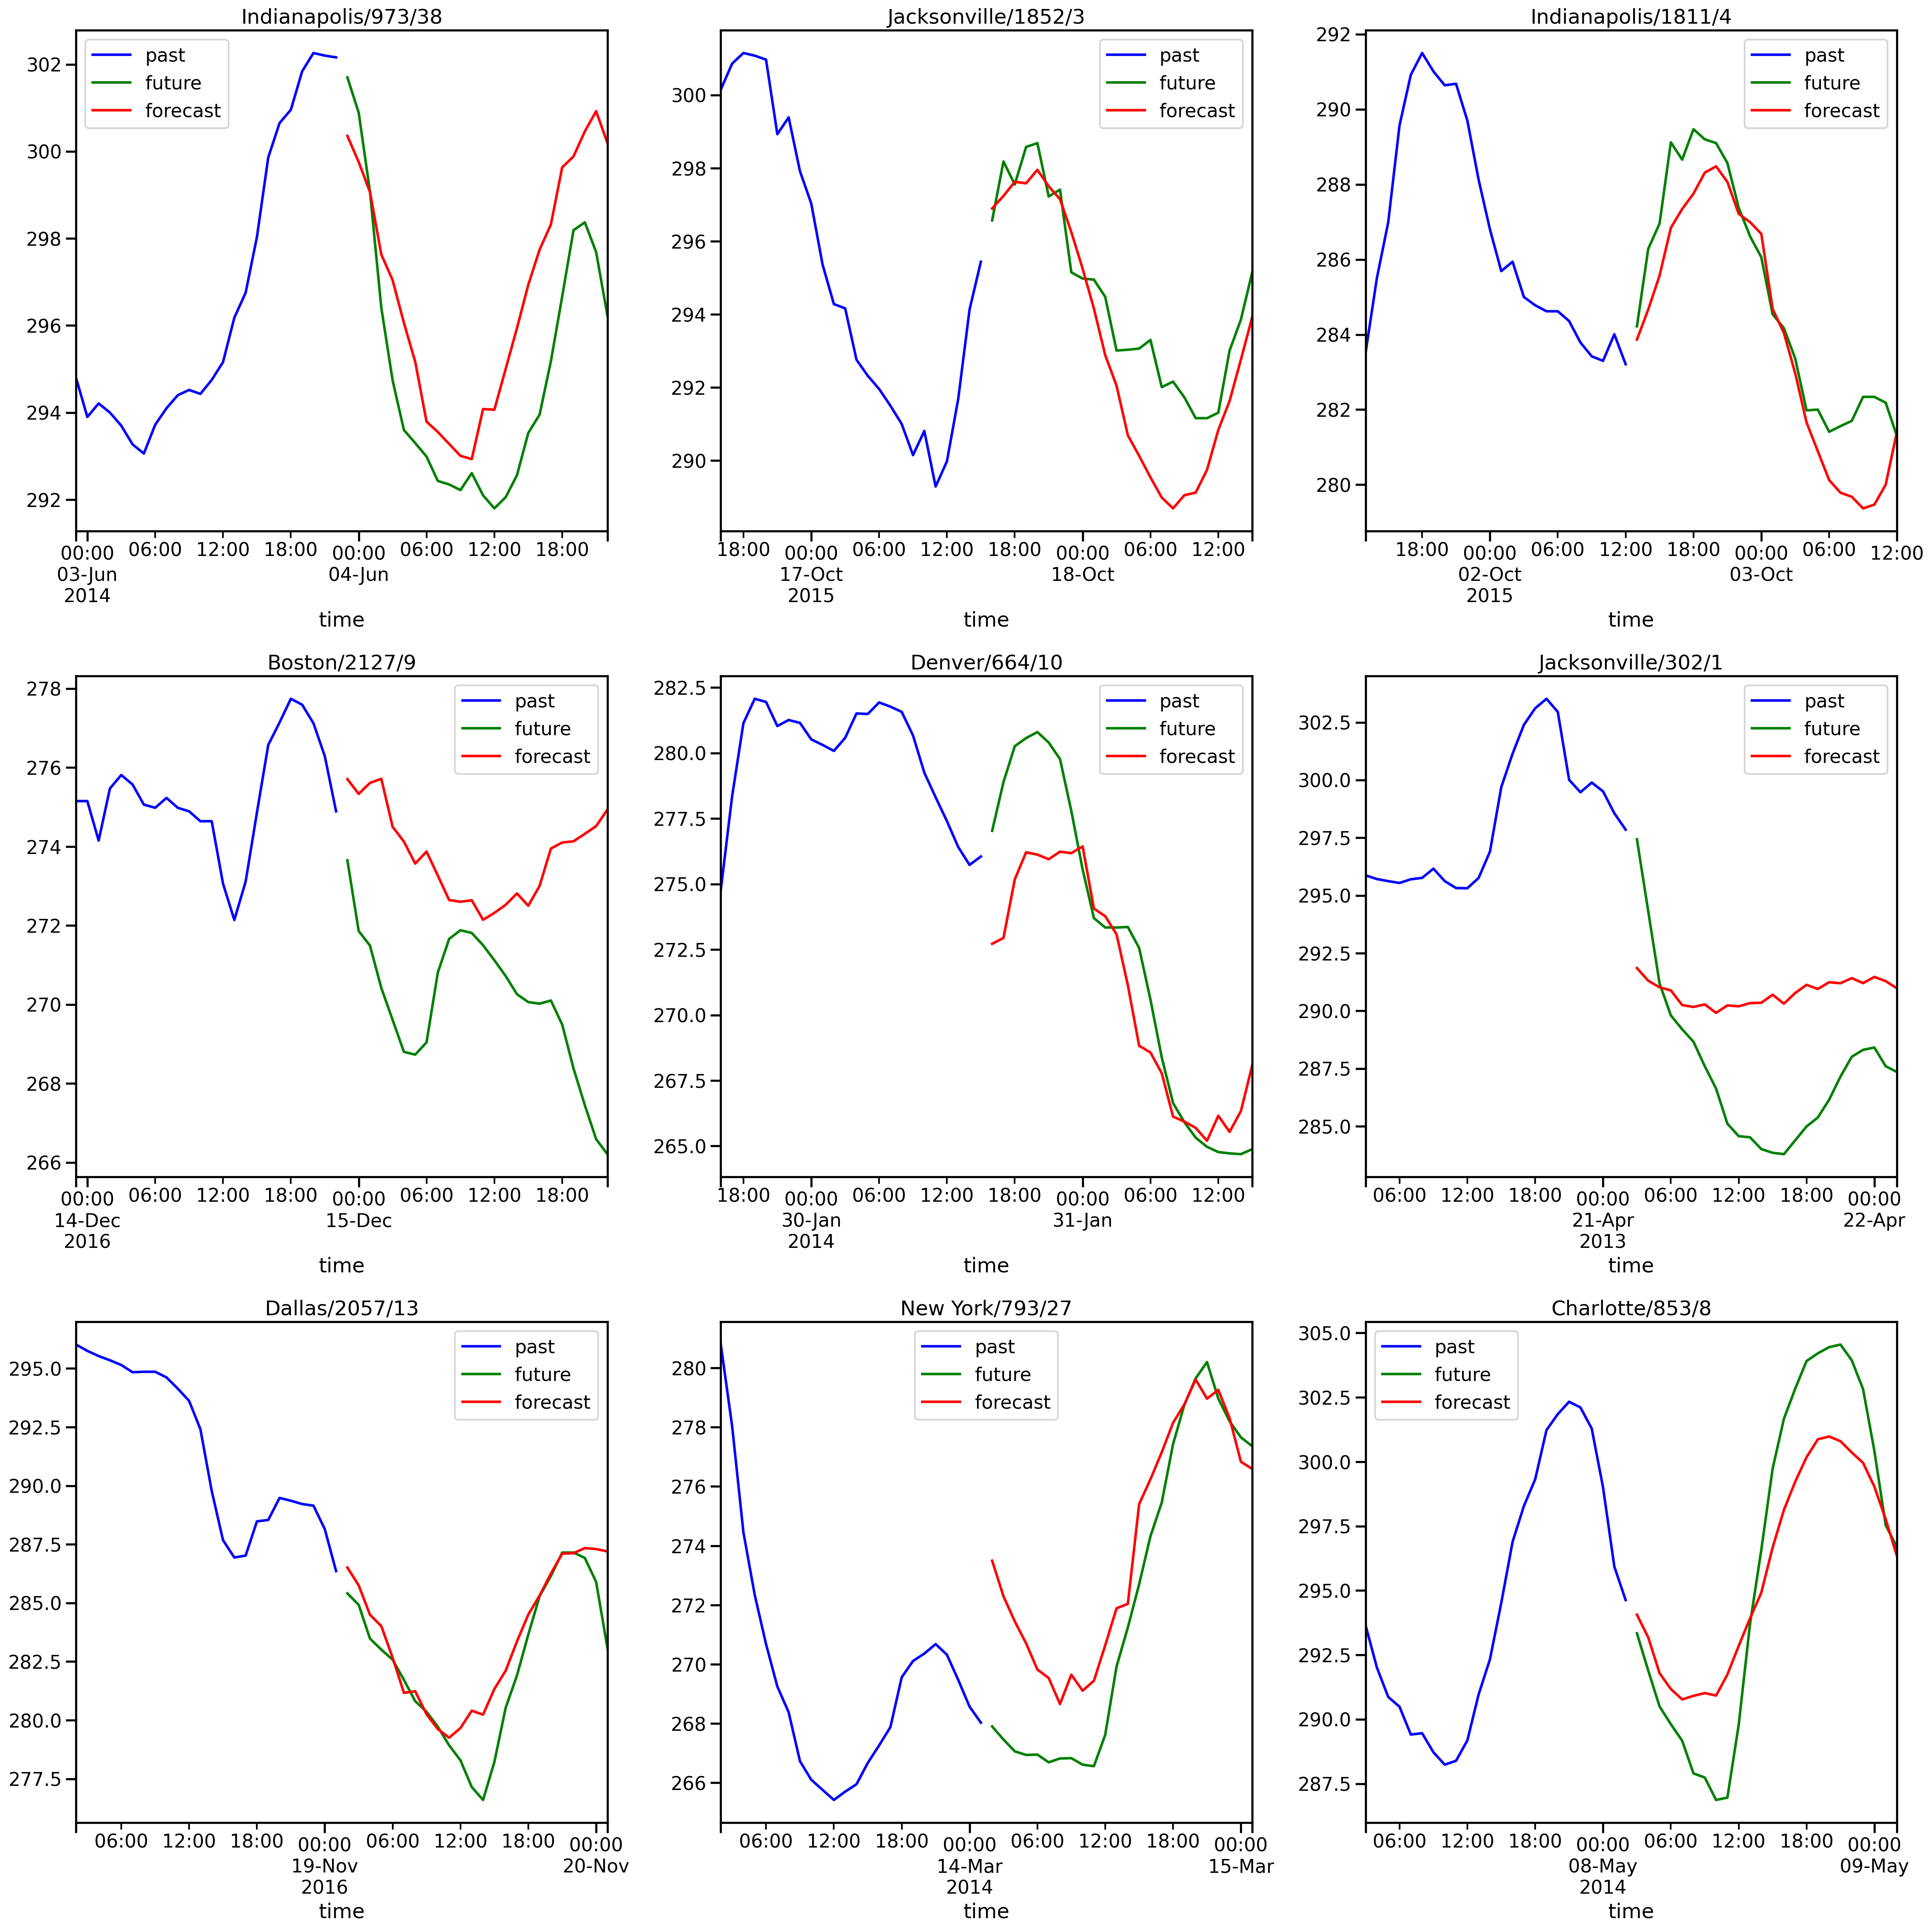

In [27]:
from utils import nd_target_like_panel, plot_random_forecasts

train_y_hat = nd_target_like_panel(train_y, model.predict(train_X_nd))

plot_random_forecasts(
    train_X['temperature'],
    train_y['temperature'],
    train_y_hat.rename(columns={'temperature': 'forecast'})
)

140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


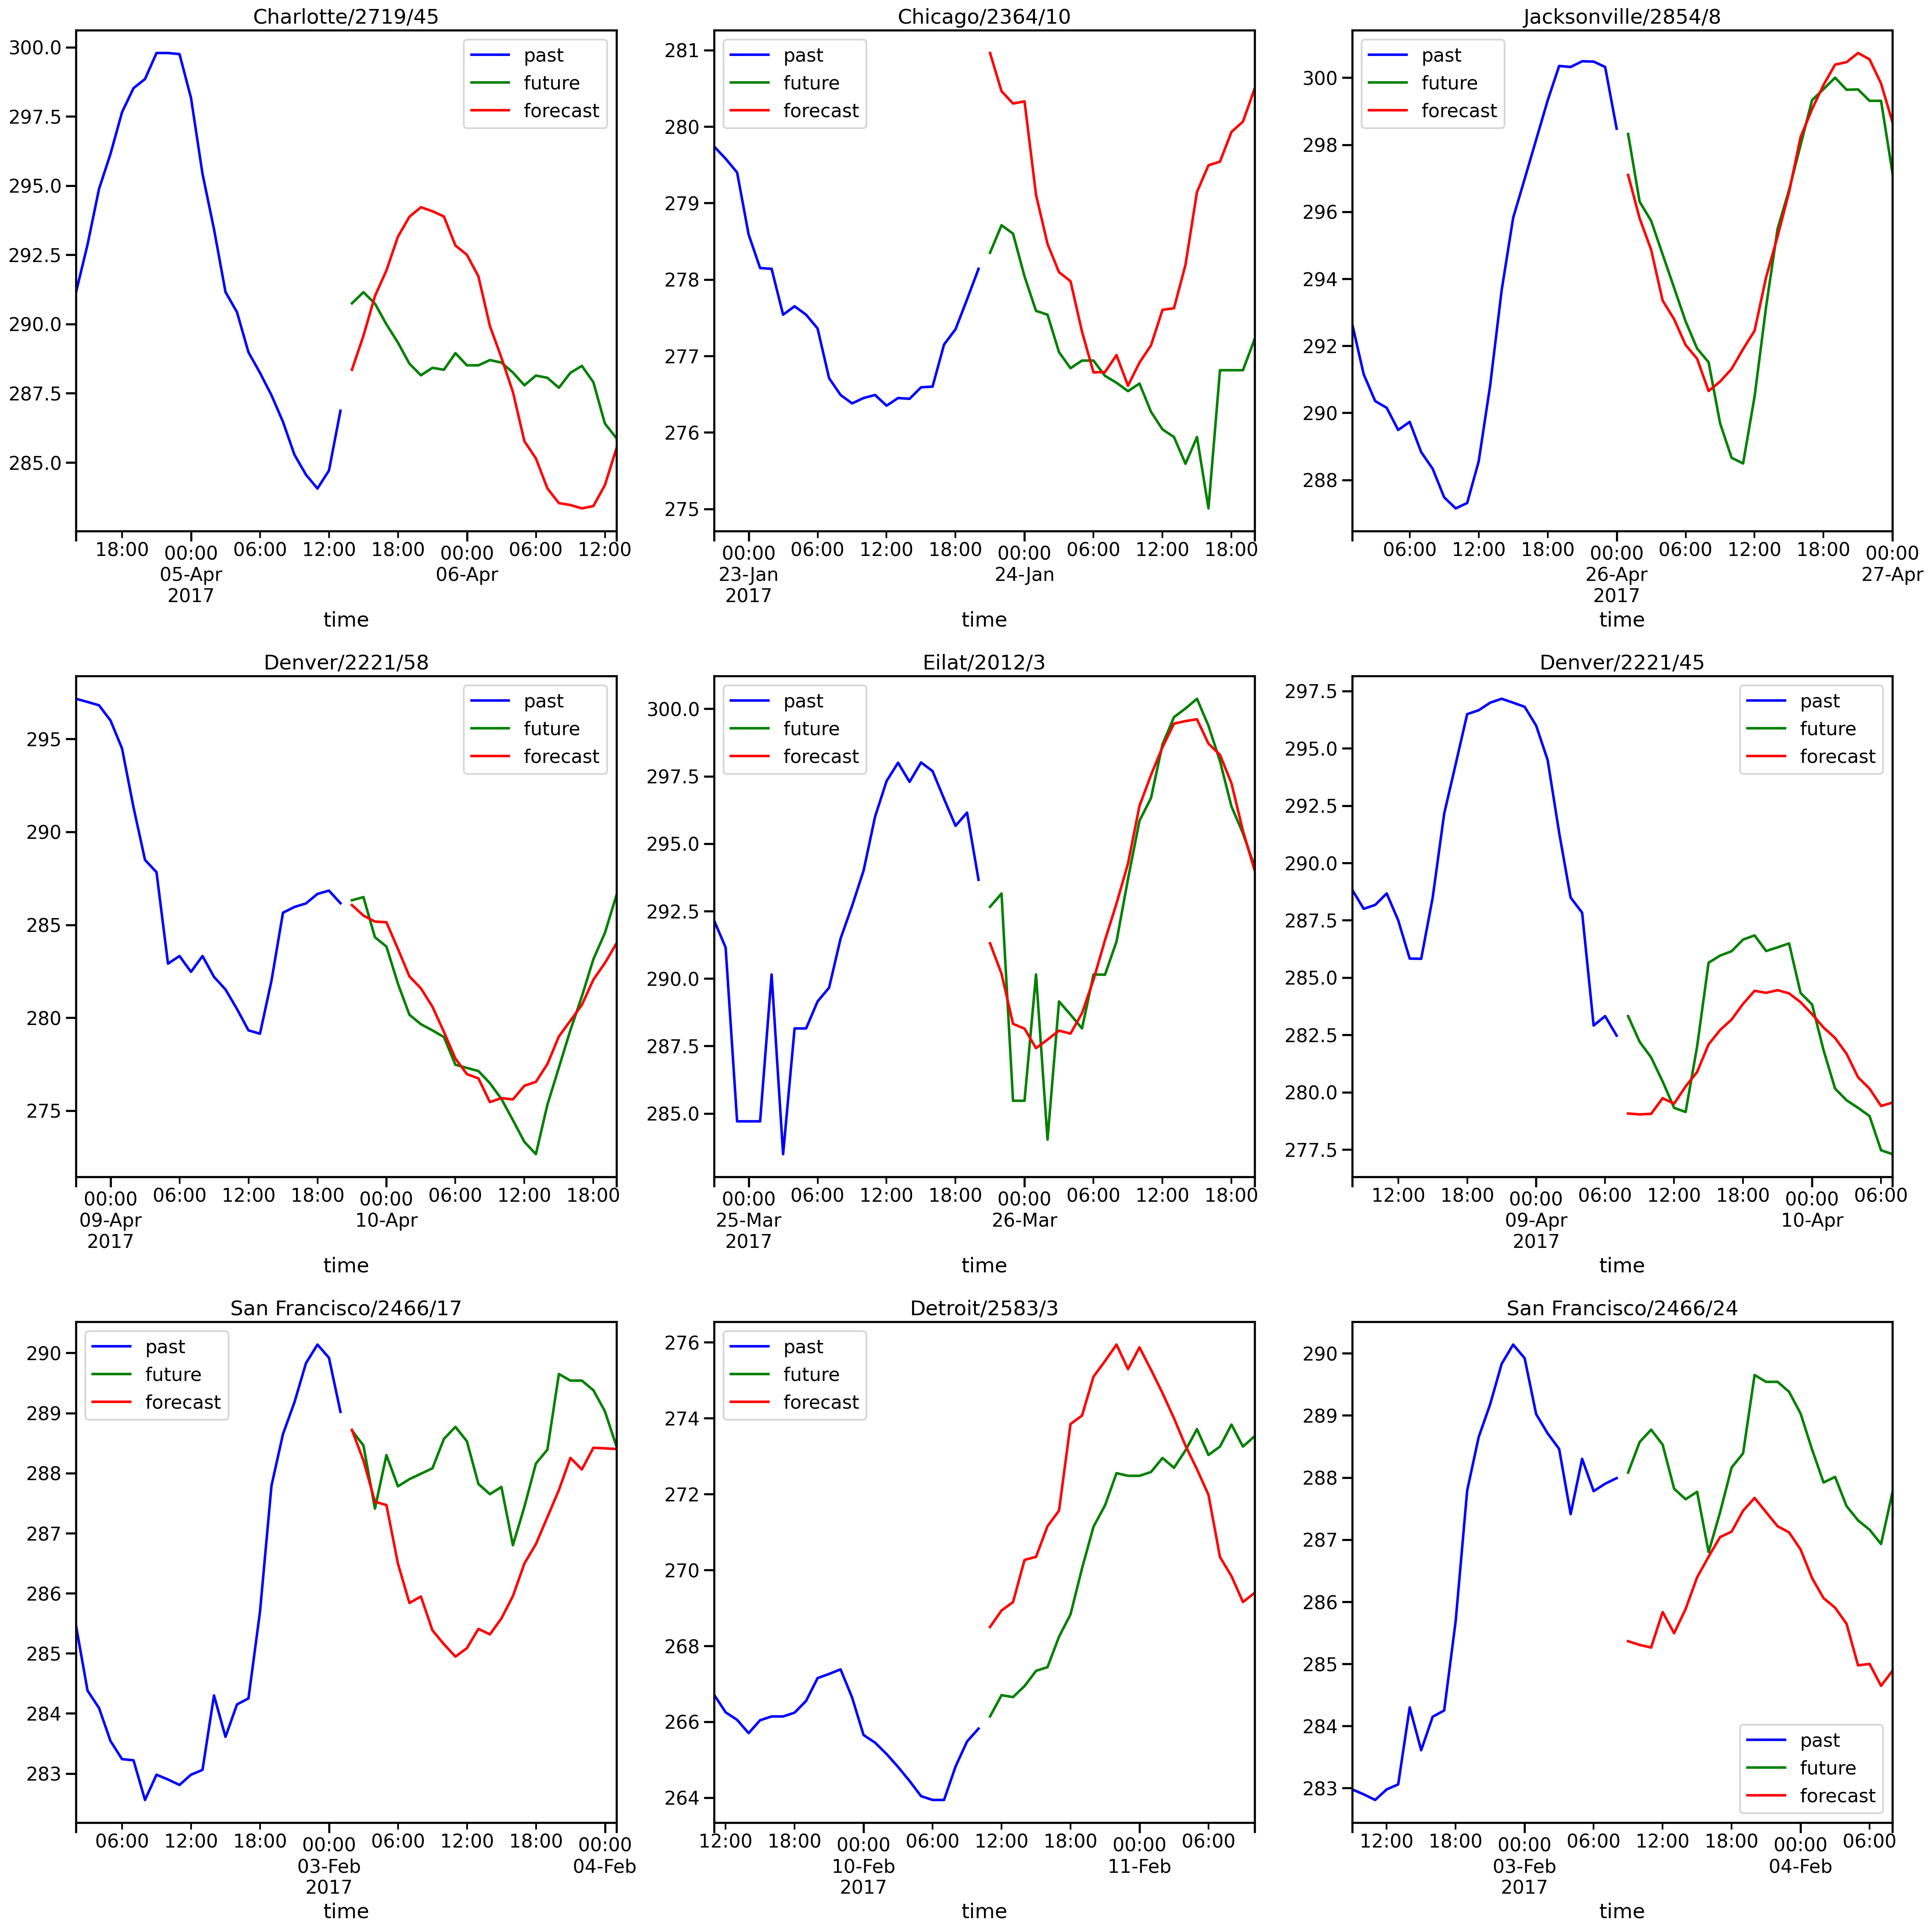

In [29]:
from utils import nd_target_like_panel, plot_random_forecasts

# Generate predictions on the test dataset
test_y_hat = nd_target_like_panel(test_y, model.predict(test_X_nd))

# Plot random forecasts to compare actual vs. predicted temperatures
plot_random_forecasts(
    test_X['temperature'],   # Input feature data for plotting context
    test_y['temperature'],   # Actual temperature from the test set
    test_y_hat.rename(columns={'temperature': 'forecast'})  # Predicted temperatures
)


In [30]:
from utils import SegmentDataset, baseline_metrics

segment_names = ['train', 'validate']
panel_dataset = SegmentDataset.from_pq_workdir(prefix, segment_names, ['x', 'y'])
baseline_metrics = baseline_metrics(panel_dataset)

/home/sagemaker-user/collegium/m03_rnn/utils.py:263: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return reg.stack("time")
/home/sagemaker-user/collegium/m03_rnn/utils.py:263: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return reg.stack("time")


In [31]:
# into a variable named score_y_hat.
import numpy as np
import pandas as pd
import os
import json

# Keras model will output an array of shape (2399, 24) for the Score segment,
# however the expected shape of the submitted data frame is (57576, 1).
# 57576 = 2399 (count of samples in Score segment) x 24 (prediction window).
score_predictions = model.predict(score_X_nd)

# Reshape the predictions from shape (2399, 24) to (57576, 1)
# Using ravel to flatten the array into the correct format
score_y_hat = pd.DataFrame(score_predictions.ravel(), columns=['temperature'])

# Check the shape and column name of the prediction DataFrame
print(score_y_hat.columns, score_y_hat.shape)  # Expected: (Index(['temperature'], dtype='object'), (57576, 1))



75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Index(['temperature'], dtype='object') (57576, 1)


In [ ]:
print(

In [34]:
# from utils import nd_target_like_panel, plot_random_forecasts

# # Plot random forecasts to compare actual vs. predicted temperatures
# plot_random_forecasts(
#     score_X['temperature'],   # Input feature data for plotting context
#     score_X['temperature'],   # Actual temperature from the test set
#     test_y_hat.rename(columns={'temperature': 'forecast'})  # Predicted temperatures
# )

In [35]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. temperature forecast for the Score segment

import os
model_dir = 'weathernet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.weights.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

In [39]:
# pd.concat([
#     baseline_metrics,
#     rnn_metrics
# ], axis=0).loc[:, [('train', 'MSE'), ('train', 'R2'), ('validate', 'MSE'), ('validate', 'R2')]].round(2)

In [38]:
# TODO: save your predictions on the Score segment as a Pandas data frame
# into a variable named score_y_hat.
score_y_hat = pd.DataFrame()

# Keras model will output an array of shape (2399, 24) for the Score segment,
# however the expected shape of the submitted data frame is (57576, 1).
# 57576 = 2399 (count of samples in Score segment) x 24 (prediction window).
# Use NumPy's reshape() or ravel() functions to achieve this.

# Finally, the data frame needs to have string column names in order to be saved
# as a Parquet file. If you convert a NumPy array to Pandas data frame,
# column names will be integers, but you can replace the columns names.
# There was a similar example of this in the notebook from the first assignment.

# Expected output: (Index(['temperature'], dtype='object'), (57576, 1))
score_y_hat.columns, score_y_hat.shape

(RangeIndex(start=0, stop=0, step=1), (0, 0))

In [41]:
print(score_y_hat)

Empty DataFrame
Columns: []
Index: []


In [ ]:
################################# IGNORE THE CELLS BELOW #########################################################

In [ ]:
# train_X.loc['Albuquerque/1112/1'].plot(subplots=True, layout=(2, 2), figsize=[15, 10])
# plt.tight_layout()

In [ ]:
# train_y.loc['Albuquerque/1112/1'].head(24)

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(train_X)

# scaled_X = {
#     'train': scaler.transform(train_X),
#     'validate': scaler.transform(validate_X),
#     'test': scaler.transform(test_X),
#     'score': scaler.transform(score_X),
# }

In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # Define the model architecture
# model = Sequential([
#     LSTM(128, return_sequences=True, input_shape=(condition_window, train_X.shape[2])),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     LSTM(64, return_sequences=True),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     LSTM(32, return_sequences=False),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     Dense(prediction_window, activation='linear')
# ])

# # Compile the model
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='mean_squared_error',
#     metrics=['mean_absolute_error']
# )

# # Display the model summary
# model.summary()

# # Callbacks for training
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
# ]



In [ ]:
# Train the model
# history = model.fit(
#     train_X_final, train_y,
#     validation_data=(validate_X_final, validate_y),
#     epochs=10,  # Adjust as needed
#     batch_size=64,  # Adjust as needed
#     callbacks=callbacks,
#     verbose=1
# )




In [ ]:
# # Evaluate the model on the test dataset
# test_loss, test_mae = model.evaluate(test_X_seqs, test_y_seqs)
# print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# # Visualize the training process
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# from keras.layers import GRU, Dense, BatchNormalization
# from keras.models import Sequential
# from keras.initializers import GlorotUniform

# # IMPORTANT: In order to pass the assignment, you need
# # to improve the architecture and/or training procedure of this model.
# # You CAN NOT submit the model as is. Please add plain English Python
# # comments on how you modified the model and/or training procedure.

# layers = [
#         GRU(
#             input_shape=(condition_window, features_length),
#             units=32,
#             return_sequences=True,  # support another recurrent layer below
#             kernel_initializer=GlorotUniform(seed=42),
#             recurrent_initializer=GlorotUniform(seed=43),
#             use_cudnn=True,
#         ),
#         BatchNormalization(),
#         GRU(
#             units=16,
#             return_sequences=False,  # only use the last activation for prediction
#             kernel_initializer=GlorotUniform(seed=46),
#             recurrent_initializer=GlorotUniform(seed=47),
#             use_cudnn=True,
#         ),
#         BatchNormalization(),
#         Dense(
#             units=prediction_window,
#             kernel_initializer=GlorotUniform(seed=48),
#             activation='linear'
#         )
# ]

# model = Sequential(layers)

In [ ]:
# model.summary()

In [ ]:
# from collegium.m03_rnn.utils import r2_score, mean_error
# from keras.optimizers import Adam

# # IMPORTANT: In order to pass the assignment, you need
# # to improve the architecture and/or training procedure of this model.
# # You CAN NOT submit the model as is. Please add plain English Python
# # comments on how you modified the model and/or training procedure.

# model.compile(
#     optimizer=Adam(learning_rate=0.01),
#     loss='mean_squared_error',
#     metrics=[
#         'mean_absolute_error',
#         mean_error,
#         r2_score,
#     ]
# )

In [ ]:
# %%time

# from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

# # IMPORTANT: In order to pass the assignment, you need
# # to improve the architecture and/or training procedure of this model.
# # You CAN NOT submit the model as is. Please add plain English Python
# # comments on how you modified the model and/or training procedure.

# history = model.fit(
#     train_X_nd,
#     train_y_nd,
#     validation_data=(validate_X_nd, validate_y_nd),
#     epochs=15,
#     batch_size=100,
#     callbacks=[
#         TerminateOnNaN(),
#         ReduceLROnPlateau(
#             monitor='loss',
#             min_delta=0.1,
#             patience=5,
#             factor=0.1,
#             cooldown=10,
#             verbose=1
#         ),
#         EarlyStopping(
#             monitor='loss',
#             min_delta=0.1,
#             patience=10
#         )
#     ]
# )

In [ ]:
# # Note that Keras evaluates metrics in batches,
# # which is okay for averaging-stable metrics like ME, MSE, and MAE,
# # but R2 requires full dataset to evaluate precisely.

# # This implies two things:
# # 1) R2 as reported during training is not precise
# # 2) when evaluating R2 after training, batch size must match dataset size

# nd_array_by_segment = {
#     'train': (train_X_nd, train_y_nd),
#     'validate': (validate_X_nd, validate_y_nd)
# }

# metrics_by_segment = {
#     segment: model.evaluate(
#         X_nd, 
#         y_nd, 
#         verbose=0, 
#         batch_size=2**10
#     )
#     for segment, (X_nd, y_nd) in nd_array_by_segment.items()
# }

# rnn_metrics = pd.concat([
#     pd.DataFrame(
#         data=[metrics], 
#         columns=['MSE', 'MAE', 'ME', 'R2'], 
#         index=[segment]
#     )
#     for segment, metrics in metrics_by_segment.items()
# ])

# rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
#     .swaplevel(axis=1, i=0, j=1)\
#     .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
#     .round(2)

# rnn_metrics